#### Import Dependencies

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [6]:
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.recurrent import LSTM
from keras.layers import Merge, Input, concatenate, GaussianNoise
from keras.layers import LeakyReLU
from keras.layers import Bidirectional

### Load the Training Data

In [7]:
inputData = pd.read_csv('trainData_set1.csv')

#### Replace Upcylce and Downcycle to Up and Down in the Indicative Tick Direction Column

In [8]:
inputData.TICKDIR.describe()

count     52396
unique        5
top        FLAT
freq      47029
Name: TICKDIR, dtype: object

In [9]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN          1685
DOWNCYCLE     1163
FLAT         47029
UP            1665
UPCYCLE        854
Name: TIME, dtype: int64

In [10]:
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')

In [11]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     2848
FLAT    47029
UP       2519
Name: TIME, dtype: int64

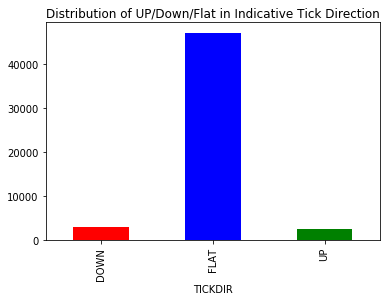

In [12]:
subset.plot(kind='bar', title='Distribution of UP/Down/Flat in Indicative Tick Direction',
           color=['red','blue','green']);

#### Extract a single feature - bid ask imbalance

In [13]:
# extracting a single feature
X = inputData.BIDASKIMBALANCE

#### Reshaping X as it has only one feature

In [14]:
X = np.array(X).reshape(-1,1)

In [15]:
X.shape

(52396, 1)

### Multi Classification 

#### Converting the Indicative Tick Direction to numerical format

In [16]:
y = inputData.TICKDIR.replace('UP', 1)
y = y.replace('FLAT', 0)
y = y.replace('DOWN', -1)

In [17]:
y.shape

(52396,)

In [18]:
y = np.array(y).reshape(-1,1)

#### Reshaping X and Y for ingesting into the model

In [19]:
print("The shape of X is: ",X.shape)
print("The shape of y is: ",y.shape)

The shape of X is:  (52396, 1)
The shape of y is:  (52396, 1)


In [20]:
X = X.reshape(X.shape[0],1, X.shape[1])
y = y.reshape(y.shape[0],1, y.shape[1])
print("The shape of x is: ",X.shape)
print("The shape of y is: ",y.shape)

The shape of x is:  (52396, 1, 1)
The shape of y is:  (52396, 1, 1)


#### Train test split

In [21]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.10, random_state=0)

#### Sequencing the data

In [22]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [23]:
# define input sequence
in_seq1 = np.array(X_train0)
#in_seq2 = np.array(df_Normal_train.n_0935.values)
out_seq = np.array(y_train0)

In [24]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
#in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [25]:
# horizontally stack columns
dataset = np.hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 10
# convert into input/output
X_train, y_train = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

In [26]:
y_train.shape

(47147,)

In [59]:
X_train.shape

(47147, 10, 1)

#### Define model

In [60]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001, amsgrad=True),  loss='binary_crossentropy', metrics = ['accuracy'])

In [61]:
# define model
model = Sequential()
#model.add(Bidirectional(LSTM(50, activation='relu',return_sequences=True), input_shape=(n_steps, n_features)))
#model.add(Bidirectional(LSTM(50, activation='relu',return_sequences=True), input_shape=(n_steps, n_features)))
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics =['accuracy'])

#### Train model

In [62]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_split = 0.25)

Train on 35360 samples, validate on 11787 samples
Epoch 1/10
35360/35360 [==============================] - 13s 367us/step - loss: 0.0867 - acc: 0.8972 - val_loss: 0.0843 - val_acc: 0.8984
Epoch 2/10
35360/35360 [==============================] - 11s 325us/step - loss: 0.0848 - acc: 0.8972 - val_loss: 0.0842 - val_acc: 0.8984
Epoch 3/10
35360/35360 [==============================] - 12s 336us/step - loss: 0.0842 - acc: 0.8971 - val_loss: 0.0821 - val_acc: 0.8984
Epoch 4/10
35360/35360 [==============================] - 12s 326us/step - loss: 0.0818 - acc: 0.8988 - val_loss: 0.0805 - val_acc: 0.9032
Epoch 5/10
35360/35360 [==============================] - 12s 328us/step - loss: 0.0801 - acc: 0.9003 - val_loss: 0.0785 - val_acc: 0.9037
Epoch 6/10
35360/35360 [==============================] - 12s 334us/step - loss: 0.0792 - acc: 0.9014 - val_loss: 0.0784 - val_acc: 0.9050
Epoch 7/10
35360/35360 [==============================] - 12s 332us/step - loss: 0.0787 - acc: 0.9014 - val_loss: 0.

#### Plot Loss and Accuracy 

In [63]:
from matplotlib import pyplot

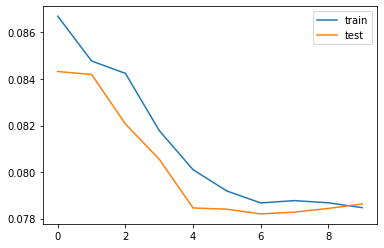

In [64]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

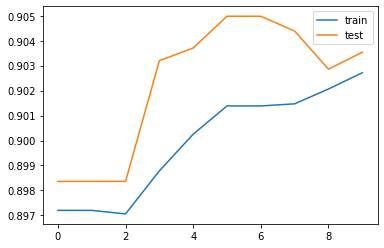

In [65]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

#### Sequencing Testing Data

In [66]:
# define input sequence
in_seq1 = np.array(X_test0)
#in_seq2 = np.array(df_Normal_train.n_0935.values)
out_seq = np.array(y_test0)

In [67]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
#in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [68]:
# horizontally stack columns
dataset = np.hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 10
# convert into input/output
X_test, y_test = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_test.shape[2]

In [69]:
X_test[0]

array([[-0.14147147],
       [ 0.62014626],
       [-0.21740248],
       [ 0.68597142],
       [ 0.17434548],
       [ 0.91645013],
       [-0.77109128],
       [-0.10808687],
       [ 0.27685686],
       [ 0.68251516]])

In [70]:
X_test[1]

array([[ 0.62014626],
       [-0.21740248],
       [ 0.68597142],
       [ 0.17434548],
       [ 0.91645013],
       [-0.77109128],
       [-0.10808687],
       [ 0.27685686],
       [ 0.68251516],
       [ 0.10532249]])

#### Make a prediction

In [71]:
prediction = model.predict(X_test)

In [72]:
prediction.shape

(5231, 1)

In [73]:
prediction[:10,0]

array([ 1.2188033e-01,  3.1131338e-03,  1.4123493e-01,  2.5983900e-06,
        3.2172449e-02,  2.4699447e-01,  1.6274946e-02, -2.5293237e-02,
        1.1372218e-01,  5.8199751e-01], dtype=float32)

In [74]:
prediction = prediction.reshape(prediction.shape[0],prediction.shape[1])


In [75]:
actualized = y_test.reshape(y_test.shape[0], 1)

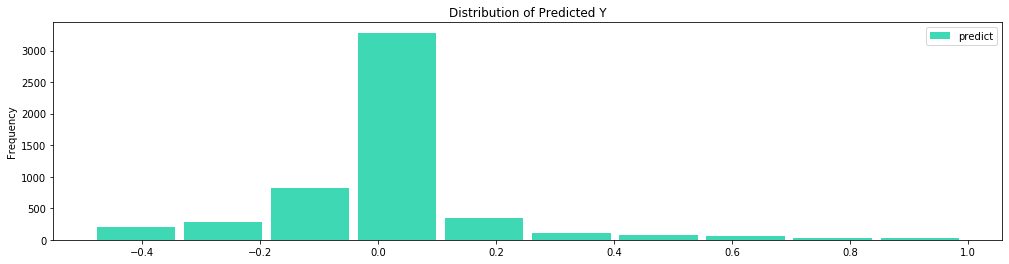

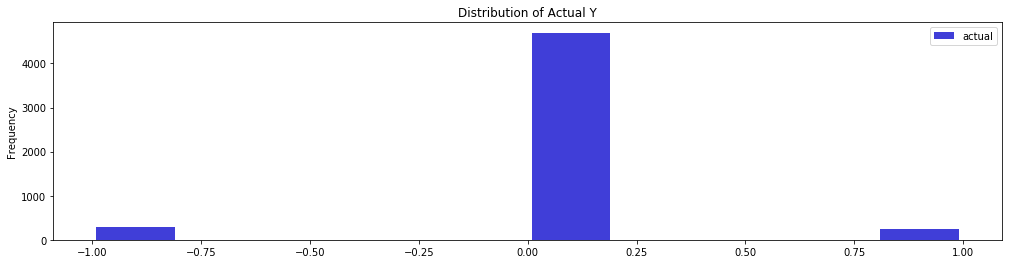

In [76]:
predicted = pd.DataFrame({'predict': prediction[:,0]})
predicted.plot.hist( figsize = (17,4), title ='Distribution of Predicted Y', color ='#3ed8b4', rwidth=0.9);
plt.show();
actual = pd.DataFrame({'actual':actualized[:,0]})
actual.plot.hist( figsize = (17,4), title ='Distribution of Actual Y', color ='#403ed8', rwidth=0.9);
plt.show();

#### Set threshold for inference

In [91]:
inferenceHolder = []
for p in predicted.predict:
    infer = 0
    
    if p > 0.15:
        infer = 1
    if p < -0.15:
        infer = -1
    inferenceHolder.append(infer)

In [92]:
inferred = pd.DataFrame({'infer': inferenceHolder})

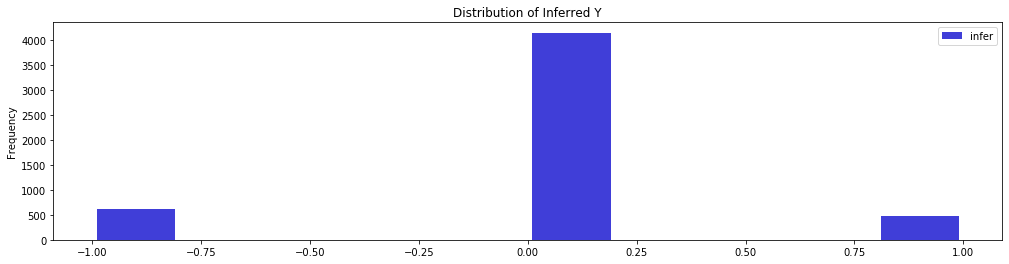

In [93]:
inferred.plot.hist( figsize = (17,4), title ='Distribution of Inferred Y', color ='#403ed8', rwidth=0.9);
plt.show();

In [94]:
x = actual.actual * 1
y = inferred.infer * 1
diff = x - y
xy = pd.DataFrame({'actual': x, 'inferred': y, 'diff': diff})

The Summary of difference is:
      actual  inferred
diff                  
-2.0       2         2
-1.0     422       422
 0.0    4272      4272
 1.0     533       533
 2.0       2         2
The Percentage difference is:
         actual   inferred
diff                      
-2.0   0.038234   0.038234
-1.0   8.067291   8.067291
 0.0  81.666985  81.666985
 1.0  10.189256  10.189256
 2.0   0.038234   0.038234


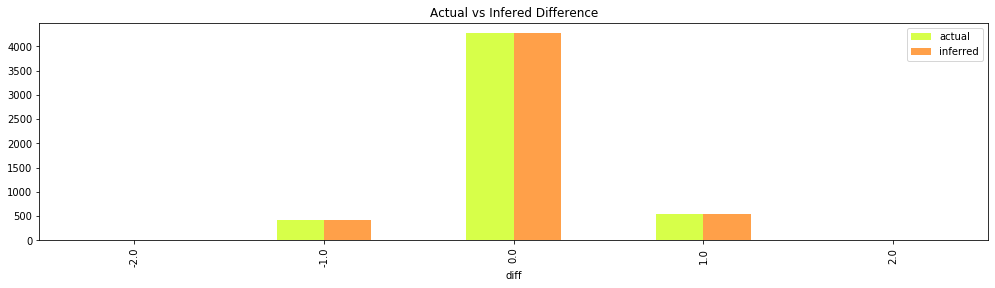

In [95]:
summary3 = xy.groupby(['diff']).count()
print('The Summary of difference is:')
print(summary3)
summary4 = (summary3 / len(xy)) * 100
print('The Percentage difference is:')
print(summary4)
summary3.plot.bar(figsize = (17,4), title='Actual vs Infered Difference', color = ('#d7ff49','#ffa049'));

#### Confusion Matrix

In [96]:
y_pred = np.array(inferenceHolder)

In [97]:
y_pred = y_pred.reshape(y_pred.shape[0],1)

In [98]:
y_pred.shape

(5231, 1)

In [99]:
y_test.shape

(5231, 1)

In [100]:
y_test = y_test.reshape(y_test.shape[0],1)

In [101]:
y_test.shape

(5231, 1)

In [102]:
confusion_matrix(y_test, y_pred)

array([[ 172,  106,    2],
       [ 436, 3946,  316],
       [   2,   97,  154]])

#### Accuracy Score

In [103]:
accuracy_score(y_test, y_pred)

0.8166698528006118

#### Classification Report

#### Precision:
- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

- The best value is 1 and the worst value is 0.

#### Recall:
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
- The recall is intuitively the ability of the classifier to find all the positive samples.

- The best value is 1 and the worst value is 0.

#### F-1 Score:
- The F1 score can be interpreted as a weighted average of the precision and recall.
- An F1 score reaches its best value at 1 and worst score at 0.
- The relative contribution of precision and recall to the F1 score are equal.
- F1 = 2 x (precision x recall) / (precision + recall)

In [104]:
print(classification_report(y_test, y_pred, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.28      0.61      0.39       280
           0       0.95      0.84      0.89      4698
           1       0.33      0.61      0.42       253

    accuracy                           0.82      5231
   macro avg       0.52      0.69      0.57      5231
weighted avg       0.89      0.82      0.84      5231

